# Hierarchical Inference with Redshift Samples

This notebook applies the results from 2.1-2.3 to infer individual and population redshift distributions from an arbitrary collection of noisy redshift PDFs. This allows us to wrap up most of the critical ideas that will later be extended over $p$-D photometric PDFs.

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(7)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated and utilized in 2.1.

In [3]:
downsample = 10  # downsampling the population
survey = pickle.load(open('../data/mock_sdss_polletta_bpz.pkl', 'rb'))  # load data
types = survey.data['types'][::downsample]
templates = survey.data['templates'][::downsample]
redshifts = survey.data['redshifts'][::downsample]
mags = survey.data['refmags'][::downsample]
Nobs = len(types)

# Population Redshift Density Estimation

For every observed galaxy $g \in \mathbf{g}$ out of $N_\mathbf{g}$ galaxies, let's assume we have an associated redshift estimate $z_g$ with PDF $P(z_g | z)$. We can construct an estimate for the population redshift distribution $N(z|\mathbf{g})$ by projecting our results onto a relevant **redshift basis** $\lbrace \dots, P(z_h|z) = K(z_h|z), \dots \rbrace$ indexed by $h \in \mathbf{h}$ via

$$
P(g|h) \rightarrow P(z_g|z_h) = \frac{P(z_g, z_h)}{P(z_h)} = \frac{\int P(z_g | z) K(z_h | z) P(z) dz}{\sum_{g \in \mathbf{g}} \int P(z_g | z) K(z_h | z) P(z) dz}
$$

where the notation $K(z_h|z)$ is meant to suggest a **kernel density** and differentiate it from $P(z_g|z)$.

In 2.1, we showed how these can be used to construct different estimates of the population distribution using different basis functions, namely Tophat kernels (i.e. bins) and Gaussian kernels. These are plotted below.

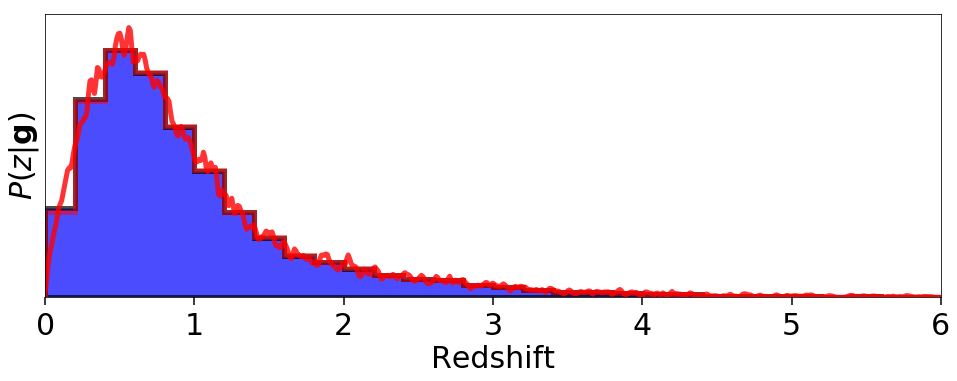

In [4]:
# bins
zbins = np.arange(0, 6.+1e-5, 0.2)  # redshift bins

# KDE
zgrid = np.arange(-1., 7.+1e-5, 0.01)
Ngrid, sgrid = len(zgrid), 0.01
pdf = frankenz.pdf.gauss_kde(redshifts, np.ones(Nobs) * sgrid, zgrid)
pdf /= np.trapz(pdf, zgrid)

# plotting
plt.figure(figsize=(14, 6))
nz, _, _ = plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
                    color='blue', alpha=0.7, normed=True, edgecolor='black')
plt.plot(zgrid, pdf, lw=5, color='red', alpha=0.8)
plt.hist(zgrid + 1e-5, bins=zbins, weights=pdf, histtype='step', lw=5,
         color='red', alpha=0.5, normed=True)
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel('$P(z|\mathbf{g})$')
plt.tight_layout()

Let's define our PDFs to be Gaussian $\mathcal{N}(z|\mu=\hat{z}_g, \sigma=\sigma_g)$ centered around noisy estimates $\hat{z}_g$ with error $\hat{\sigma}_g$. These are truncated at $z=0$ to avoid unphysical results.

In [5]:
# generate PDFs
sigma = np.random.uniform(0.05, 0.2, size=Nobs)  # width
cdf_draws = np.random.rand(Nobs)  # draw [0, 1]
mu = np.random.normal(redshifts, sigma)  # noisy observation
zpdf = np.array([frankenz.pdf.gaussian(mu[i], sigma[i], zgrid) 
                 for i in range(Nobs)])  # redshift pdfs
zpdf /= np.trapz(zpdf, zgrid)[:,None]  # normalizing (dealing with edge effects)

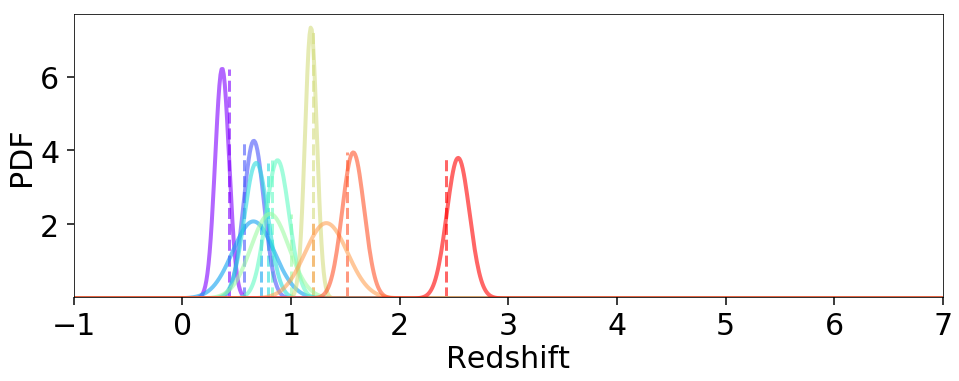

In [6]:
# plot some PDFs
plt.figure(figsize=(14, 6))
Nplot = 10
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
zidxs = np.random.choice(Nobs, size=Nplot)
zidxs = zidxs[np.argsort(redshifts[zidxs])]
for i, c in zip(zidxs, colors):
    plt.plot(zgrid, zpdf[i], color=c, lw=4, alpha=0.6)
    plt.vlines(redshifts[i], 0., max(zpdf[i]), color=c, 
               lw=3, linestyles='--', alpha=0.6)
plt.xlim([zgrid[0], zgrid[-1]])
plt.ylim([0.03, None])
plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.tight_layout()

Commonly, it is assumed that "stacking" these PDFs such that

$$
N(z|\mathbf{g}) \stackrel{?}{=} \sum_{g \in \mathbf{g}} \mathcal{N}(z|\mu=\hat{z}_g, \sigma=\hat{\sigma}_g)
$$

will give access to the population distribution. Evaluated over a particular (discrete) basis $\mathbf{h}$, we can write the effective number density $\boldsymbol{\Lambda}_\mathbf{g}$ from this stacked distribution as

$$ \boldsymbol{\Lambda}_\mathbf{g} = \sum_{g \in \mathbf{g}} \mathbf{p}_g $$

where $\mathbf{p}_g$ is the **probability mass function (PMF)** (i.e. the discrete PDF) for galaxy $g$ over our chosen basis. So far, this has been either tophat kernels (bins) or Gaussian kernels.

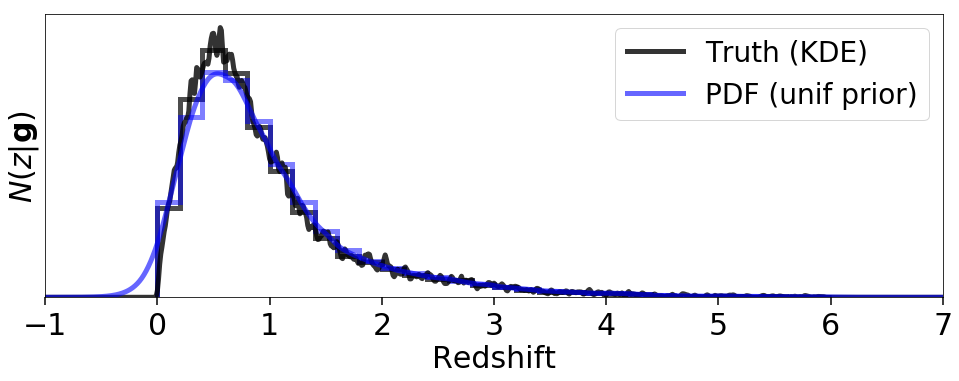

In [7]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='blue',
         alpha=0.6, label='PDF (unif prior)')
plt.hist(redshifts, bins=zbins, histtype='step', lw=5,
         color='black', alpha=0.7, normed=True)
plt.hist(zgrid + 1e-5, bins=zbins, weights=zpdf.sum(axis=0) / Nobs,
         histtype='step', lw=5,
         color='blue', alpha=0.5, normed=True)
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylabel('$N(z|\mathbf{g})$')
plt.ylim([0., None])
plt.legend(fontsize=28, loc='best')
plt.tight_layout()

As shown in the previous notebooks, this is not actually a fully accurate reconstruction of the true PDF -- our noise broadens the estimated population redshift distribution (especially at the low redshift end).

# From Grids to Samples

So far we've assumed that our basis functions indexed by $h \in \mathbf{h}$ correspond to a grid in redshift $z_h \in \mathbf{z}$. Above, we found that to properly reproduce the "correct" $P(z|\mathbf{g})$ we need to incorporate a redshift prior $P(z)$. Given our discrete grid, this translates to a set of discrete priors $P(z_h) \equiv P(h)$ over $\mathbf{h}$, where our basis over $\mathbf{h}$ just *happens* to correspond to a grid in redshift $\mathbf{z}$. As stated above, this is just

$$
P(g|h) = \frac{\int P(z_g | z) P(z_h | z) P(z) dz}{\sum_{g \in \mathbf{g}} \int P(z_g | z) P(z_h | z) P(z) dz}
$$

We now want to take advantage of two key insights:
1. Our choice of basis is arbitrary, and we're free to pick our $h \in \mathbf{h}$ and their corresponding $\lbrace \dots, P(z_h|z), \dots \rbrace$ however we'd like.
2. Our basis itself can indirectly provide information on our prior.

In particular, if we assume that $h \in \mathbf{h}$ is a **(Poisson) point process**, where our objects are drawn from an underlying $P(z)$ distribution (i.e. the "true" prior), then aggregating information over these redshift samples is *fundamentally equivalent* in the limit where $n \rightarrow \infty$ to weighting a set of predictions computed over a redshift grid $\mathbf{z}$ by our corresponding prior $P(\mathbf{z})$. In other words, we just transition from a prior imposed directly via $P(z)$ to a prior imposed indirectly via the associated number densities of objects in $\mathbf{h}$.

From a **machine learning** perspective, we can interpret these samples as a **training set** that we exploit to make predictions. We'll start using a bit more of this terminology to emphasize some of the connections between machine learning and this point process formalism as we move further throughout the notebooks.

## Noiseless Samples

We first consider the case where our samples are noiseless and drawn directly from the redshift distribution of interest (i.e. $P(z_h|z) = \delta(z_h - z)$. As argued above, we'll take $P(h)=1$ for all $h \in \mathbf{h}$. Our posterior then becomes

$$
P(h|g) = \frac{P(h,g)}{P(g)} = \frac{\int P(g|z) P(z|h) P(h) dz}{\sum_{h \in \mathbf{h}} \int P(g|z) P(z|h) P(h) dz} = \frac{\mathcal{N}(\hat{z}_g|\mu=z_h,\sigma=\hat{\sigma}_g)}{\sum_{h \in \mathbf{h}} \mathcal{N}(\hat{z}_g|\mu=z_h,\sigma=\hat{\sigma}_g)} 
$$

In [8]:
# draw samples from our basis
Ntrain = 2500  # number of training samples
cdf = pdf.cumsum()  # compute unnormalized CDF
cdf /= cdf[-1]  # normalize CDF
ztrain = np.interp(np.random.rand(Ntrain), cdf, zgrid)  # sample from inverse CDF

In [9]:
# stack results
ztrain_wt = np.zeros(Ntrain)
evid_obs = np.zeros(Nobs)
chi2_obs = np.zeros(Nobs)
for i in range(Nobs):
    if i % 1000 == 0:
        sys.stderr.write('{0} '.format(i))
    wt = frankenz.pdf.gaussian(mu[i], sigma[i], ztrain)
    chi2_obs[i] = min((ztrain - mu[i])**2 / sigma[i]**2)
    evid_obs[i] = sum(wt) * Nobs
    ztrain_wt += wt / evid_obs[i]

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 

We then can estimate $P(z|\mathbf{g})$ as before using KDE.

In [10]:
# KDE
pdftrain = frankenz.pdf.gauss_kde(ztrain, np.ones(Ntrain) * sgrid, zgrid, y_wt=ztrain_wt)
pdftrain /= np.trapz(pdftrain, zgrid)

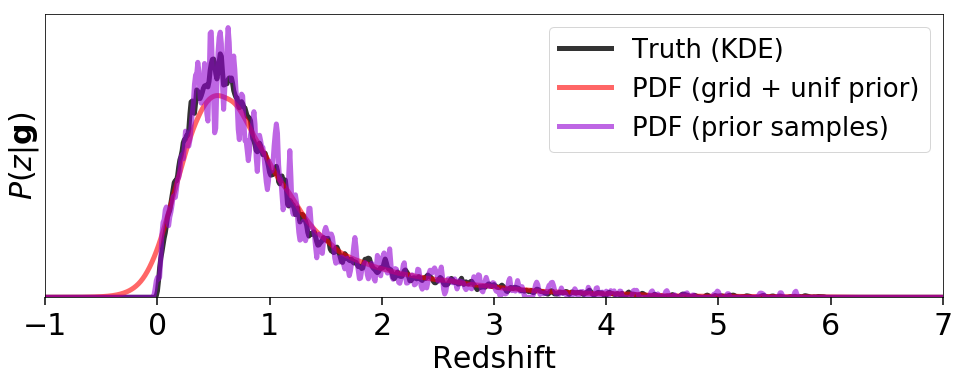

In [11]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='red',
         alpha=0.6, label='PDF (grid + unif prior)')
plt.plot(zgrid, pdftrain, lw=5, color='darkviolet', alpha=0.6,
         label='PDF (prior samples)')
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylim([0., None])
plt.ylabel('$P(z|\mathbf{g})$')
plt.legend(fontsize=26, loc='best')
plt.tight_layout()

While this estimate is accurate overall, it's subject to a some additional noise due to sampling variance. As a result, it relies on there being many samples available for estimation, especially if we want to probe the tails of the redshift distribution.

## Noisy Samples

We now consider the case where our samples/training data are *also* noisy redshift estimates characterized by a redshift PDF $P(z|h) \neq \delta(z_h - z)$. If we take these to also be Gaussian kernels with $\mathcal{N}(z|\mu=\hat{z}_h, \sigma=\hat{\sigma}_h)$, we get

$$
P(h|g) = \frac{P(h,g)}{P(g)} = \frac{\int P(g|z) P(z|h) P(h) dz}{\sum_{h \in \mathbf{h}} \int P(g|z) P(z|h) P(h) dz} = \frac{\mathcal{N}(\hat{z}_g|\mu=z_h,\sigma^2=\hat{\sigma}_g^2+\hat{\sigma}_h^2)}{\sum_{h \in \mathbf{h}} \mathcal{N}(\hat{z}_g|\mu=z_h,\sigma^2=\hat{\sigma}_g^2+\hat{\sigma}_h^2)} 
$$

In [12]:
# generate PDFs
sigma_train = np.random.uniform(0.05, 0.2, size=Ntrain)  # width
mu_train = np.random.normal(ztrain, sigma_train)  # mean

In [13]:
# stack results
ztrain_wt2 = np.zeros(Ntrain)
evid_obs2 = np.zeros(Nobs)
chi2_obs2 = np.zeros(Nobs)
for i in range(Nobs):
    if i % 1000 == 0:
        sys.stderr.write('{0} '.format(i))
    wt = frankenz.pdf.gaussian(mu_train, 
                               np.sqrt(sigma[i]**2 + sigma_train**2),
                               mu[i])
    chi2_obs2[i] = min((mu_train - mu[i])**2 / (sigma[i]**2 + sigma_train**2))
    evid_obs2[i] = sum(wt) * Nobs
    ztrain_wt2 += wt / evid_obs2[i]

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 

We now stack the corresponding kernels.

In [14]:
# KDE
pdftrain2 = frankenz.pdf.gauss_kde(mu_train, sigma_train, zgrid, y_wt=ztrain_wt2)
pdftrain2 /= np.trapz(pdftrain2, zgrid)

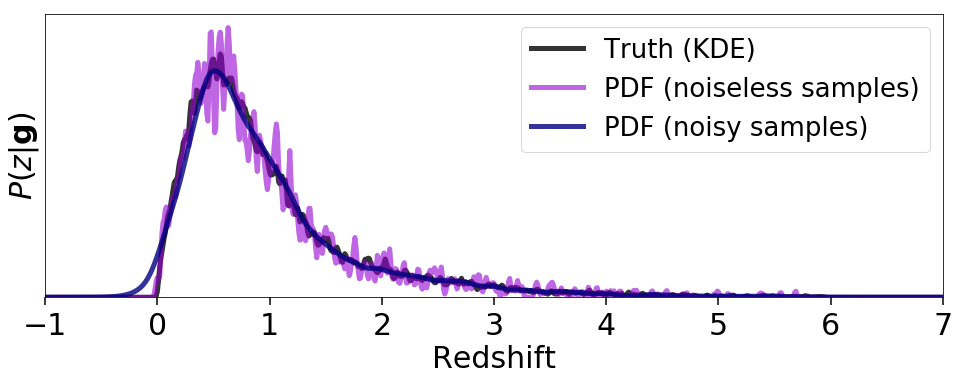

In [15]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, pdftrain, lw=5, color='darkviolet', alpha=0.6,
         label=r'PDF (noiseless samples)')
plt.plot(zgrid, pdftrain2, lw=5, color='navy', alpha=0.8,
         label=r'PDF (noisy samples)')
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylim([0., None])
plt.ylabel('$P(z|\mathbf{g})$')
plt.legend(fontsize=26, loc='best')
plt.tight_layout()

As expected, our results are similar, although our noisy kernels are starting to broaden the overall distribution the same way as the original noisy estimates.

## Sidenote: Coverage

One of the risks that becomes immediately apparent moving from grids to samples is the issue of **coverage**. In other words, our training data may not adequately cover all of the parameter space spanned by our observable PDFs.

We can diagnose this a variety of different ways, but we'll just briefly discuss two quantities: the **evidence** $P(g)$ and the best-fit $\chi^2_\min(g)$ value. The former tells us how much "overlap" our object has with the training set (basis), modulo normalizations. The latter tells us how "close" our object gets to a member of our training set. Ideally, we'd like to remove any/all objects that don't satisfy specific coverage thresholds to avoid biasing our results.

# Hierarchical Inference with Samples

Now let's imagine we have a **biased training sample**, so that it provides coverage over our observables (here $z$) but might not be exactly drawn from the prior.

In [16]:
# draw samples uniformly
ztrain = np.random.uniform(-0.2, 6.2, size=Ntrain)

# generate PDFs
sigma_train = np.random.uniform(0.05, 0.2, size=Ntrain)  # width
mu_train = np.random.normal(ztrain, sigma_train)  # mean

Since we now have likelihoods computed over a series of training objects using only our observables, we can now formulate our models directly in the **training data space**. After we draw our set of samples, it is then straightforward to **"map"** our results onto our target distribution of choice (in this case redshift).

In [17]:
# compute posteriors
post = np.zeros((Nobs, Ntrain))
for i in range(Nobs):
    if i % 1000 == 0:
        sys.stderr.write('{0} '.format(i))
    wt = frankenz.pdf.gaussian(mu_train, 
                               np.sqrt(sigma[i]**2 + sigma_train**2),
                               mu[i])
    post[i] = wt / wt.sum()
    
# stack posteriors
pstack = post.sum(axis=0)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 

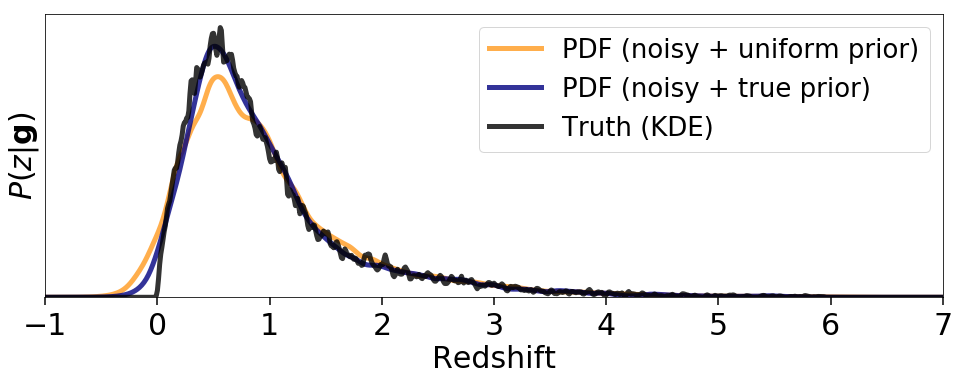

In [18]:
# KDE
pdftrain3 = frankenz.pdf.gauss_kde(mu_train, sigma_train, zgrid, y_wt=pstack)
pdftrain3 /= np.trapz(pdftrain3, zgrid)

# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdftrain3, lw=5, color='darkorange', alpha=0.7,
         label=r'PDF (noisy + uniform prior)')
plt.plot(zgrid, pdftrain2, lw=5, color='navy', alpha=0.8,
         label=r'PDF (noisy + true prior)')
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylim([0., None])
plt.ylabel('$P(z|\mathbf{g})$')
plt.legend(fontsize=26, loc='best')
plt.tight_layout()

The number density of our samples significantly distorts our inference, especially where the number density is higher. Now let's see if we can recover our overall distribution using our hierarchical model as before.

In [19]:
# number of samples
Nsamples = 50

## Poisson

In [20]:
# Poisson
train1_samples = np.array([np.random.poisson(pstack) for i in range(Nsamples)])
z1_samples = np.zeros((Nsamples, Ngrid), dtype='float')
for i in range(Nsamples):
    sys.stderr.write('{0} '.format(i))
    
    # Draw redshift samples.
    zsamps = []
    for j in range(Ntrain):
        for k in range(train1_samples[i][j]):
            zsamps.append(np.random.normal(mu_train[j], sigma_train[j]))
    z1_samples[i] = frankenz.pdf.gauss_kde(zsamps, np.ones_like(zsamps) * sgrid,
                                           zgrid)  # KDE
    z1_samples[i] *= len(zsamps) / z1_samples[i].sum()  # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

## Multinomial

In [21]:
# Multinomial
train2_samples = np.random.multinomial(Nobs, pstack / pstack.sum(),
                                       size=Nsamples)
z2_samples = np.zeros_like(z1_samples)
for i in range(Nsamples):
    sys.stderr.write('{0} '.format(i))
    zsamps = []
    for j in range(Ntrain):
        for k in range(train2_samples[i][j]):
            zsamps.append(np.random.normal(mu_train[j], sigma_train[j]))
    z2_samples[i] = frankenz.pdf.gauss_kde(zsamps, np.ones_like(zsamps) * sgrid,
                                           zgrid)  # KDE
    z2_samples[i] *= len(zsamps) / z2_samples[i].sum()  # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

## Posterior Samples

In [22]:
# Posterior
train3_samples = np.zeros_like(train2_samples)
z3_samples = np.zeros_like(z2_samples)
for i in range(Nsamples):
    sys.stderr.write('{0} '.format(i))
    zsamps = []
    for j in range(Nobs):
        train3_samples[i] += np.random.multinomial(1, post[j])
    for j in range(Ntrain):
        for k in range(train3_samples[i][j]):
            zsamps.append(np.random.normal(mu_train[j], sigma_train[j]))
    z3_samples[i] = frankenz.pdf.gauss_kde(zsamps, np.ones_like(zsamps) * sgrid,
                                           zgrid)  # KDE
    z3_samples[i] *= len(zsamps) / z3_samples[i].sum()  # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

## Initial Results

In [23]:
def zplot(samples, label='type', color='blue'):
    """Plot our draws."""
    
    [plt.plot(zgrid, samples[i], lw=2, color=color, alpha=0.07)
     for i in range(Nsamples)]
    plt.plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black',
             alpha=0.7)
    plt.plot(zgrid, pdf * 0.0 - 1e4, lw=3, color=color,
             alpha=0.5, label=label)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(pdf / pdf.sum() * Nobs) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

In [24]:
def zplot_bin(samples, label='type', color='blue', binning=5):
    """Plot our binned draws."""
    [plt.hist(zgrid + 1e-5, zgrid[::binning], 
              weights=samples[i], lw=3,
              histtype='step', color=color, alpha=0.15) 
     for i in range(Nsamples)]
    plt.hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step',
             color=color, alpha=0.6, label=label)
    h = plt.hist(redshifts, zgrid[::binning], 
                 histtype='step', lw=6, color='black', alpha=0.7)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(h[0]) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

In [25]:
def cov_draws(samples, bin1=(60, 80), bin2=(80, 100), color='blue', 
              label='label', xlim=None, ylim=None):
    """Plot our draws within two bins."""

    # Bin results.
    n, _ = np.histogram(redshifts, bins=zgrid)
    pdf_bin1 = n[bin1[0]:bin1[1]].sum() / n.sum() * Nobs / 1e3
    pdf_bin2 = n[bin2[0]:bin2[1]].sum() / n.sum() * Nobs / 1e3
    samples_bin1 = samples[:, bin1[0]:bin1[1]].sum(axis=1) / 1e3
    samples_bin2 = samples[:, bin2[0]:bin2[1]].sum(axis=1) / 1e3
    
    # Plot results.
    plt.vlines(pdf_bin1, 0, 100, lw=2, colors='black', linestyles='--')
    plt.hlines(pdf_bin2, 0, 100, lw=2, colors='black', linestyles='--')
    plt.plot(pdf_bin1, pdf_bin2, 's', color='black', markersize=20)
    plt.plot(samples_bin1, samples_bin2, 'o', color=color, 
             label=label, markersize=15, alpha=0.6)
    if xlim is None:
        plt.xlim([min(pdf_bin1, min(samples_bin1)) - 0.1, 
                  max(pdf_bin1, max(samples_bin1)) + 0.1])
    else:
        plt.xlim(xlim)
    if ylim is None:
        plt.ylim([min(pdf_bin2, min(samples_bin2)) - 0.1, 
                  max(pdf_bin2, max(samples_bin2)) + 0.1])
    else:
        plt.ylim(ylim)
    plt.xlabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin1[0]], 
                                                           zgrid[bin1[1]]))
    plt.ylabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin2[0]], 
                                                           zgrid[bin2[1]]))
    plt.legend(fontsize=28, loc=1)
    plt.tight_layout()

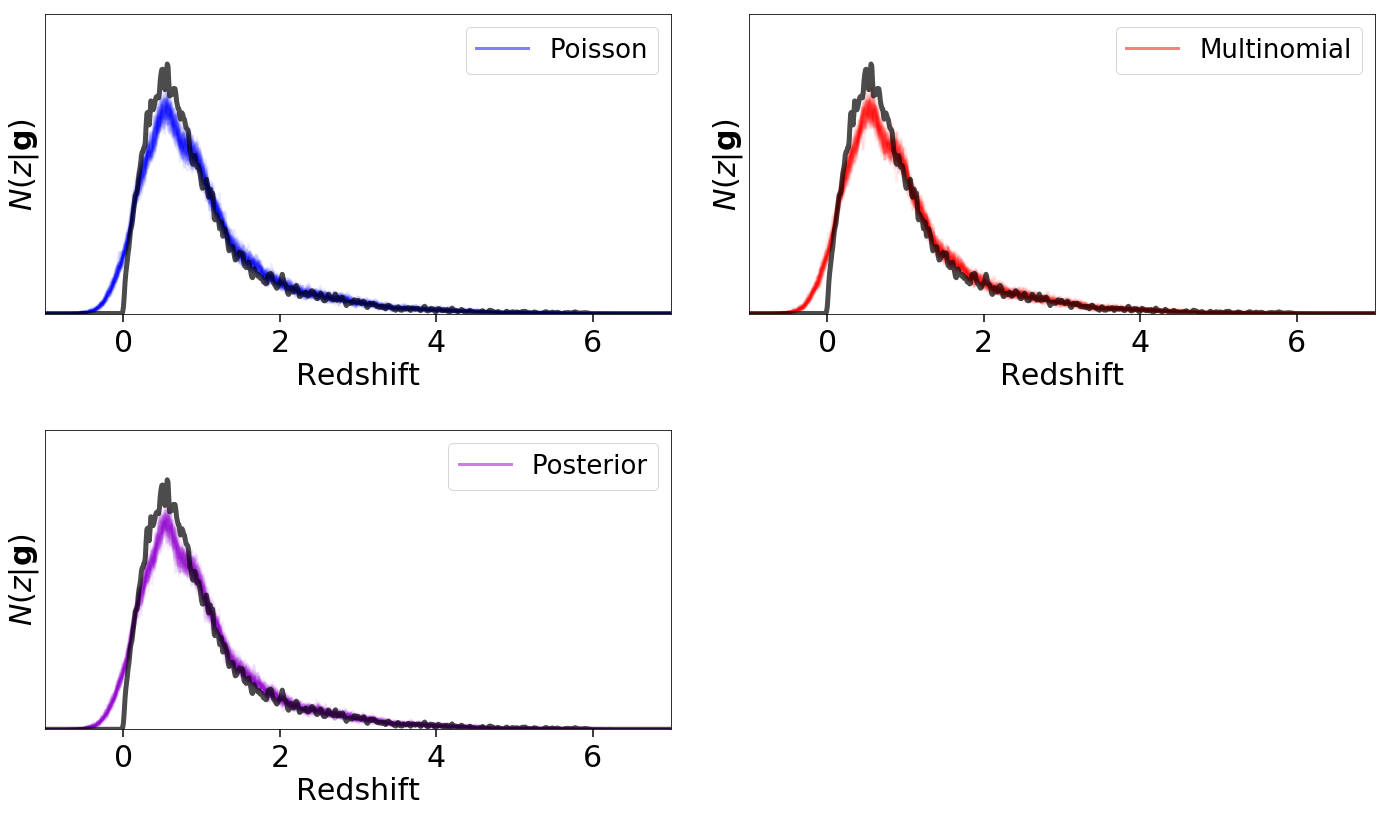

In [26]:
# plotting
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(z1_samples, label='Poisson', color='blue')
plt.subplot(2, 2, 2)
zplot(z2_samples, label='Multinomial', color='red')
plt.subplot(2, 2, 3)
zplot(z3_samples, label='Posterior', color='darkviolet')

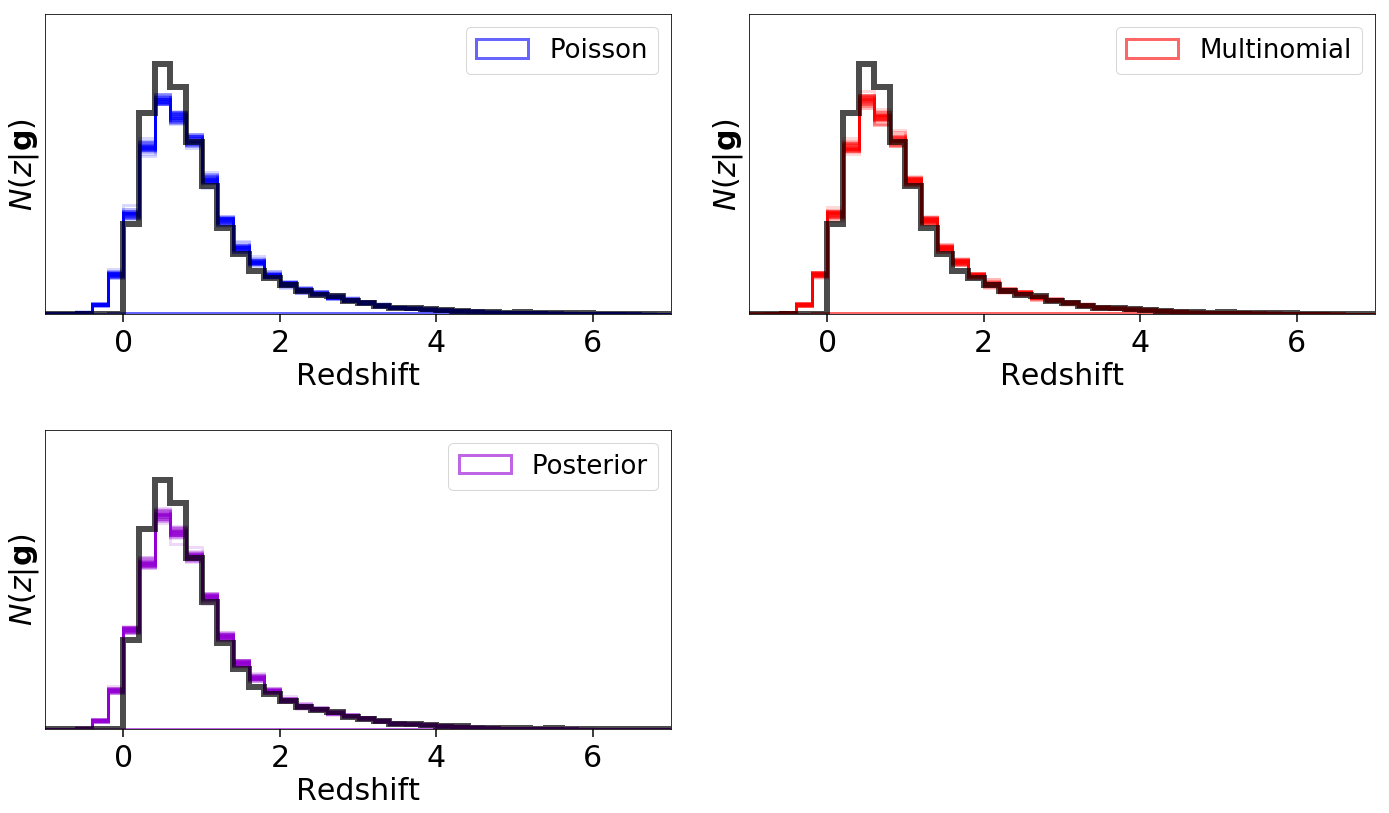

In [27]:
# plotting binned results
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot_bin(z1_samples, label='Poisson', color='blue', binning=20)
plt.subplot(2, 2, 2)
zplot_bin(z2_samples, label='Multinomial', color='red', binning=20)
plt.subplot(2, 2, 3)
zplot_bin(z3_samples, label='Posterior', color='darkviolet', binning=20)

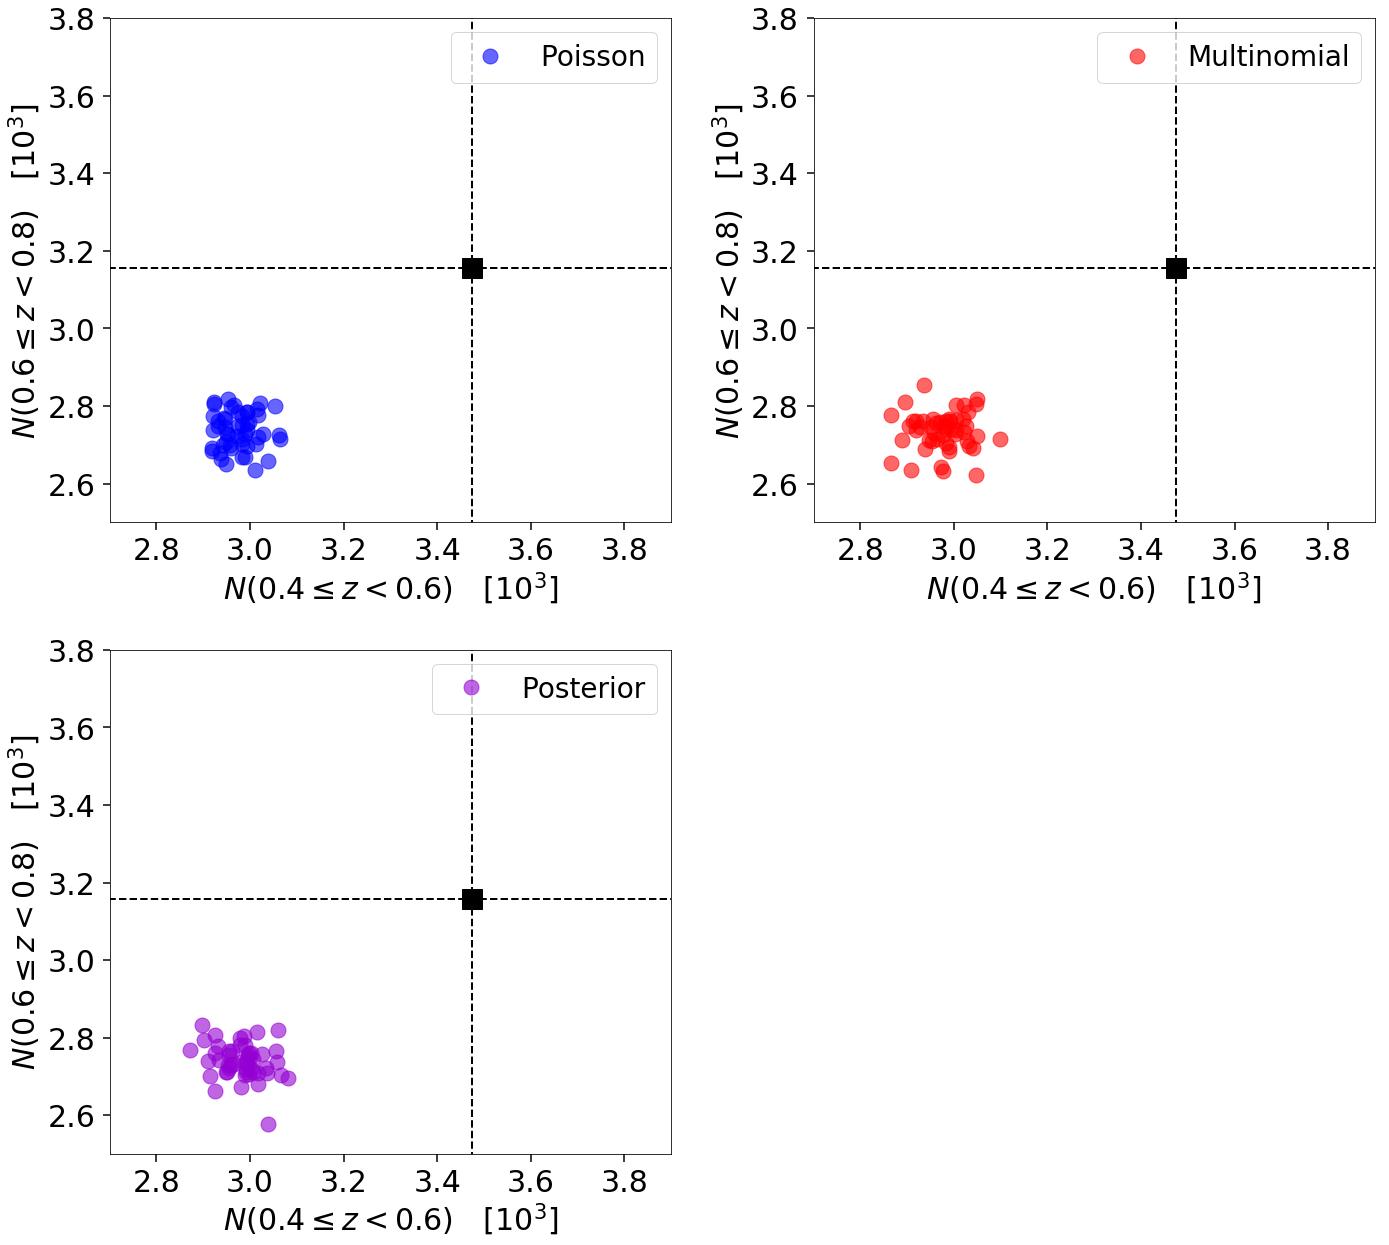

In [28]:
# plotting binned covariance
plt.figure(figsize=(20,18))
plt.subplot(2,2,1)
cov_draws(z1_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='blue', label='Poisson')
plt.subplot(2,2,2)
cov_draws(z2_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='red', label='Multinomial')
plt.subplot(2,2,3)
cov_draws(z3_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='darkviolet', label='Posterior')

## 1-Level Hierarchical

How does our 1-level hierarchical model do?

In [29]:
# initialize concentration parameters
hside = np.array(zgrid >= 0, dtype='float')  # Heavyside at z=0
alpha = np.array([np.trapz(frankenz.pdf.gaussian(m, s, zgrid) * hside, zgrid)
                  for m, s in zip(mu_train, sigma_train)])  # integrate over heavyside

In [30]:
def mcmc_gibbs(pdfs, Nsamples, Ngrid,
               Nburn=0, Nthin=1, verbose=True):
    """Using MCMC with Gibbs sampling to sample from
    the joint distribution of our hierarchical model."""
    
    Nobs = len(pdfs)
    samples_pi = np.zeros((Nsamples, Ngrid))
    samples_n = np.zeros((Nsamples, Ngrid), dtype='int')

    prior = np.ones(Ngrid)  # initialize weights
    for j in range(Nthin * (Nsamples + Nburn)):
        count = int(j / Nthin) - Nburn
        if verbose and (j + 1) % Nthin == 0: 
            sys.stderr.write('{0} '.format(count))

        # Compute new posterior.
        nstack = np.zeros(Ngrid)
        pdf_t = pdfs * prior
        pdf_t /= pdf_t.sum(axis=1)[:, None]

        # Stack posterior.
        for i in range(Nobs):
            nstack += np.random.multinomial(1, pdf_t[i])

        # Sample population weights.
        prior = np.random.dirichlet(nstack + alpha) * Nobs

        # Save samples.
        if (j + 1) % Nthin == 0 and count >= 0:
            samples_n[count] = nstack.copy()
            samples_pi[count] = prior.copy()
            
    return samples_n, samples_pi

In [31]:
# sample from our hierarchical model
train4_samples_n, train4_samples_pi = mcmc_gibbs(post, 200, Ntrain,
                                                 Nburn=0, Nthin=1)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

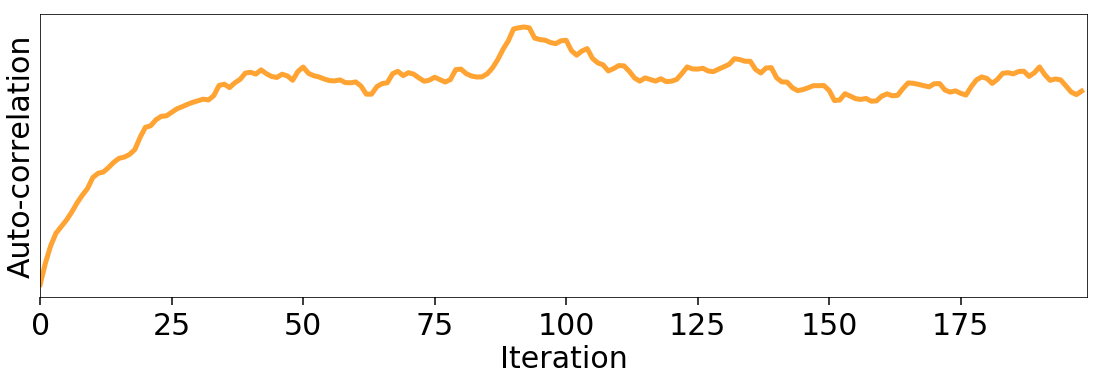

In [32]:
# plot lag=1 autocorrelation
plt.figure(figsize=(16, 6))
autocorr = np.array([np.correlate(train4_samples_pi[i], train4_samples_pi[i+1])
                     for i in range(len(train4_samples_pi) - 1)]).flatten()
plt.plot(autocorr, lw=5, color='darkorange', alpha=0.8)
plt.xlabel('Iteration')
plt.xlim([0., len(train4_samples_pi) - 1])
plt.yticks([])
plt.ylabel('Auto-correlation')
plt.tight_layout()

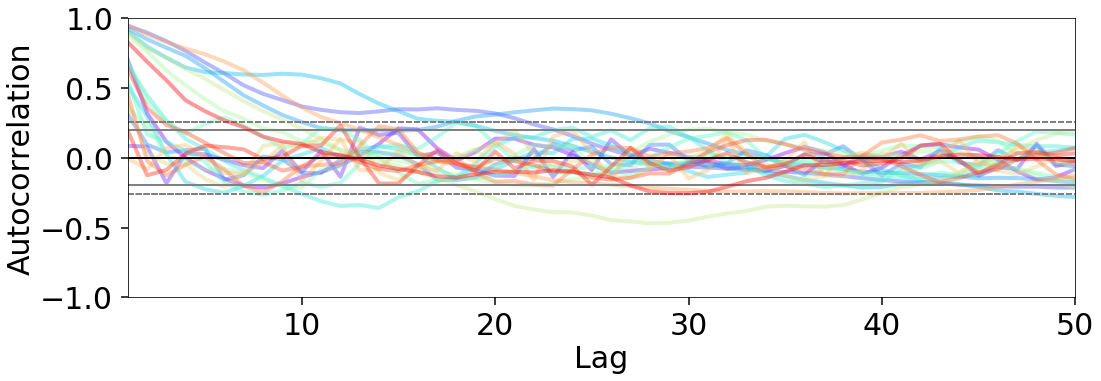

In [33]:
from pandas.plotting import autocorrelation_plot

# plot autocorrelation lag
Nburnin = 100
Nplot = 20
plt.figure(figsize=(16, 6))
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
idxs = np.random.choice(len(zgrid), size=Nplot, replace=False)
[autocorrelation_plot(train4_samples_pi[Nburnin:, i], 
                      color=c, lw=4, alpha=0.4) 
 for i, c in zip(idxs, colors)]
plt.xlim([1, (len(train4_samples_pi) - Nburnin) / 2])
plt.tight_layout()

In [34]:
# sample from our hierarchical model
train4_samples_n, train4_samples_pi = mcmc_gibbs(post, Nsamples, Ntrain,
                                                 Nburn=40, Nthin=5)

-40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

We can now convert these draws into associated redshift distributions.

In [35]:
# draw redshift samples
from scipy.stats import truncnorm
z4_samples = np.zeros_like(z3_samples)
for i in range(Nsamples):
    sys.stderr.write('{0} '.format(i))
    zsamps = []
    for j in range(Ntrain):
        for k in range(train4_samples_n[i][j]):
            zsamps.append(truncnorm.rvs(a=-mu_train[j]/sigma_train[j], b=np.inf,
                                        loc=mu_train[j], scale=sigma_train[j]))
    z4_samples[i] = frankenz.pdf.gauss_kde(zsamps, np.ones_like(zsamps) * sgrid,
                                           zgrid)  # KDE
    z4_samples[i] *= len(zsamps) / z4_samples[i].sum()  # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

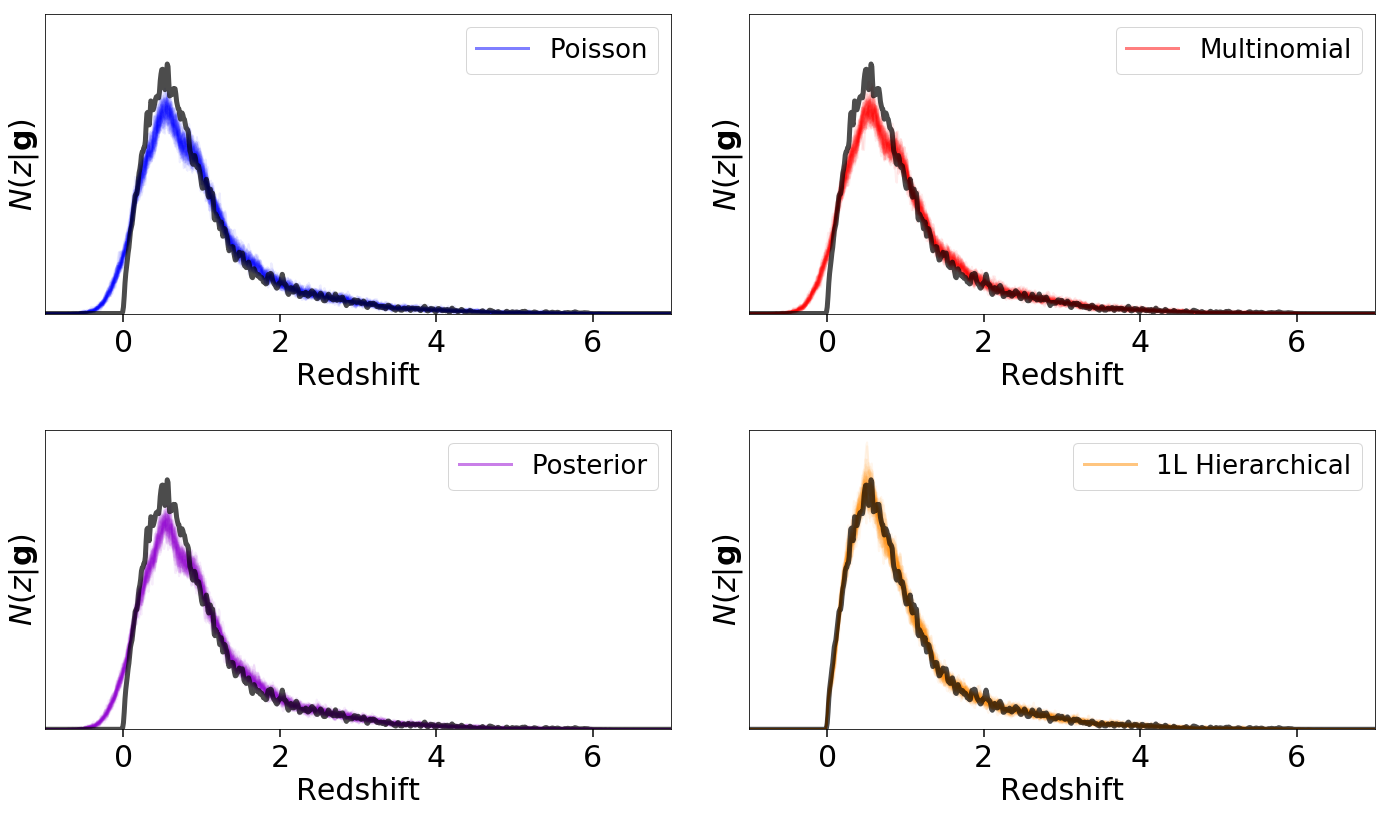

In [36]:
# plotting
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(z1_samples, label='Poisson', color='blue')
plt.subplot(2, 2, 2)
zplot(z2_samples, label='Multinomial', color='red')
plt.subplot(2, 2, 3)
zplot(z3_samples, label='Posterior', color='darkviolet')
plt.subplot(2, 2, 4)
zplot(z4_samples, label='1L Hierarchical', color='darkorange')

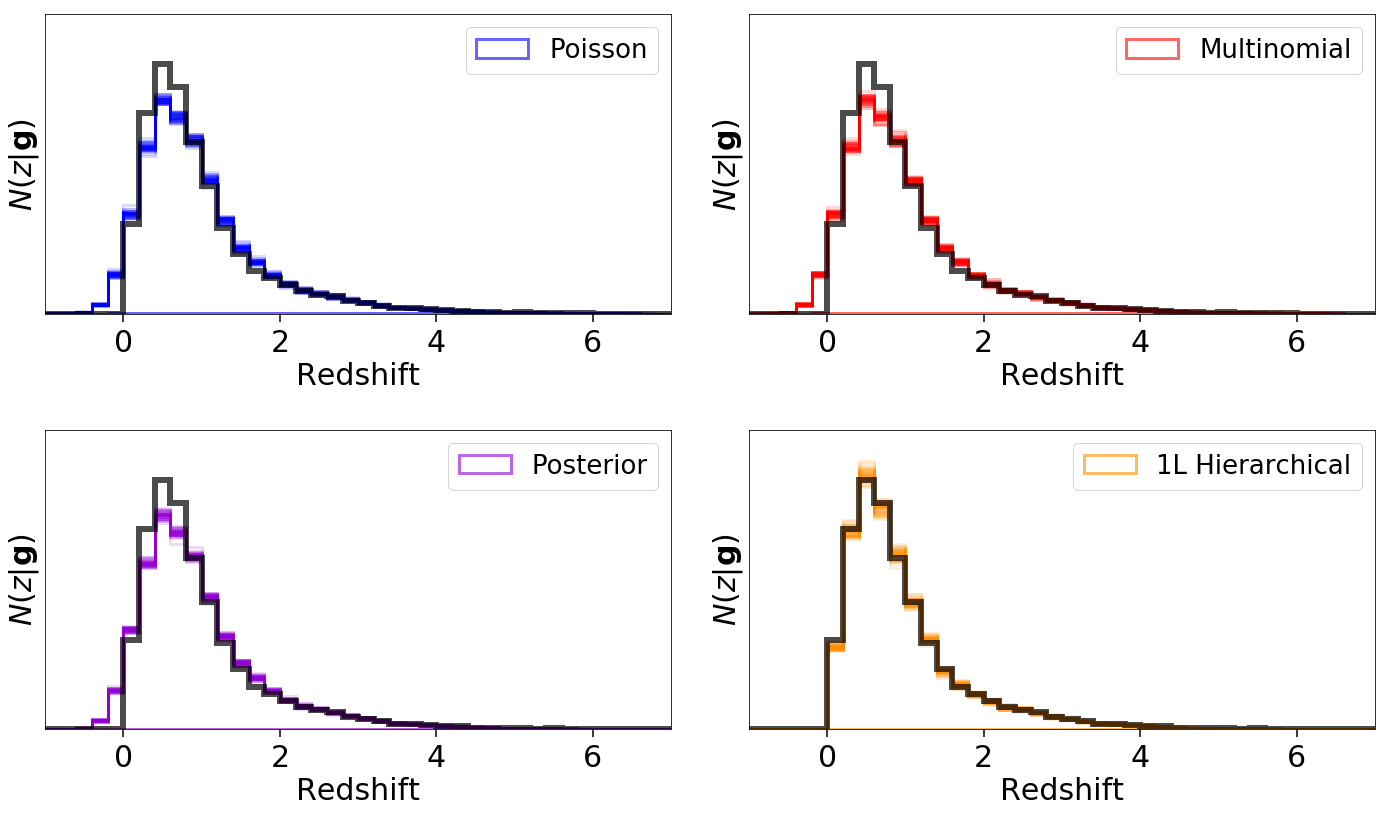

In [37]:
# plotting binned results
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot_bin(z1_samples, label='Poisson', color='blue', binning=20)
plt.subplot(2, 2, 2)
zplot_bin(z2_samples, label='Multinomial', color='red', binning=20)
plt.subplot(2, 2, 3)
zplot_bin(z3_samples, label='Posterior', color='darkviolet', binning=20)
plt.subplot(2, 2, 4)
zplot_bin(z4_samples, label='1L Hierarchical', color='darkorange', binning=20)

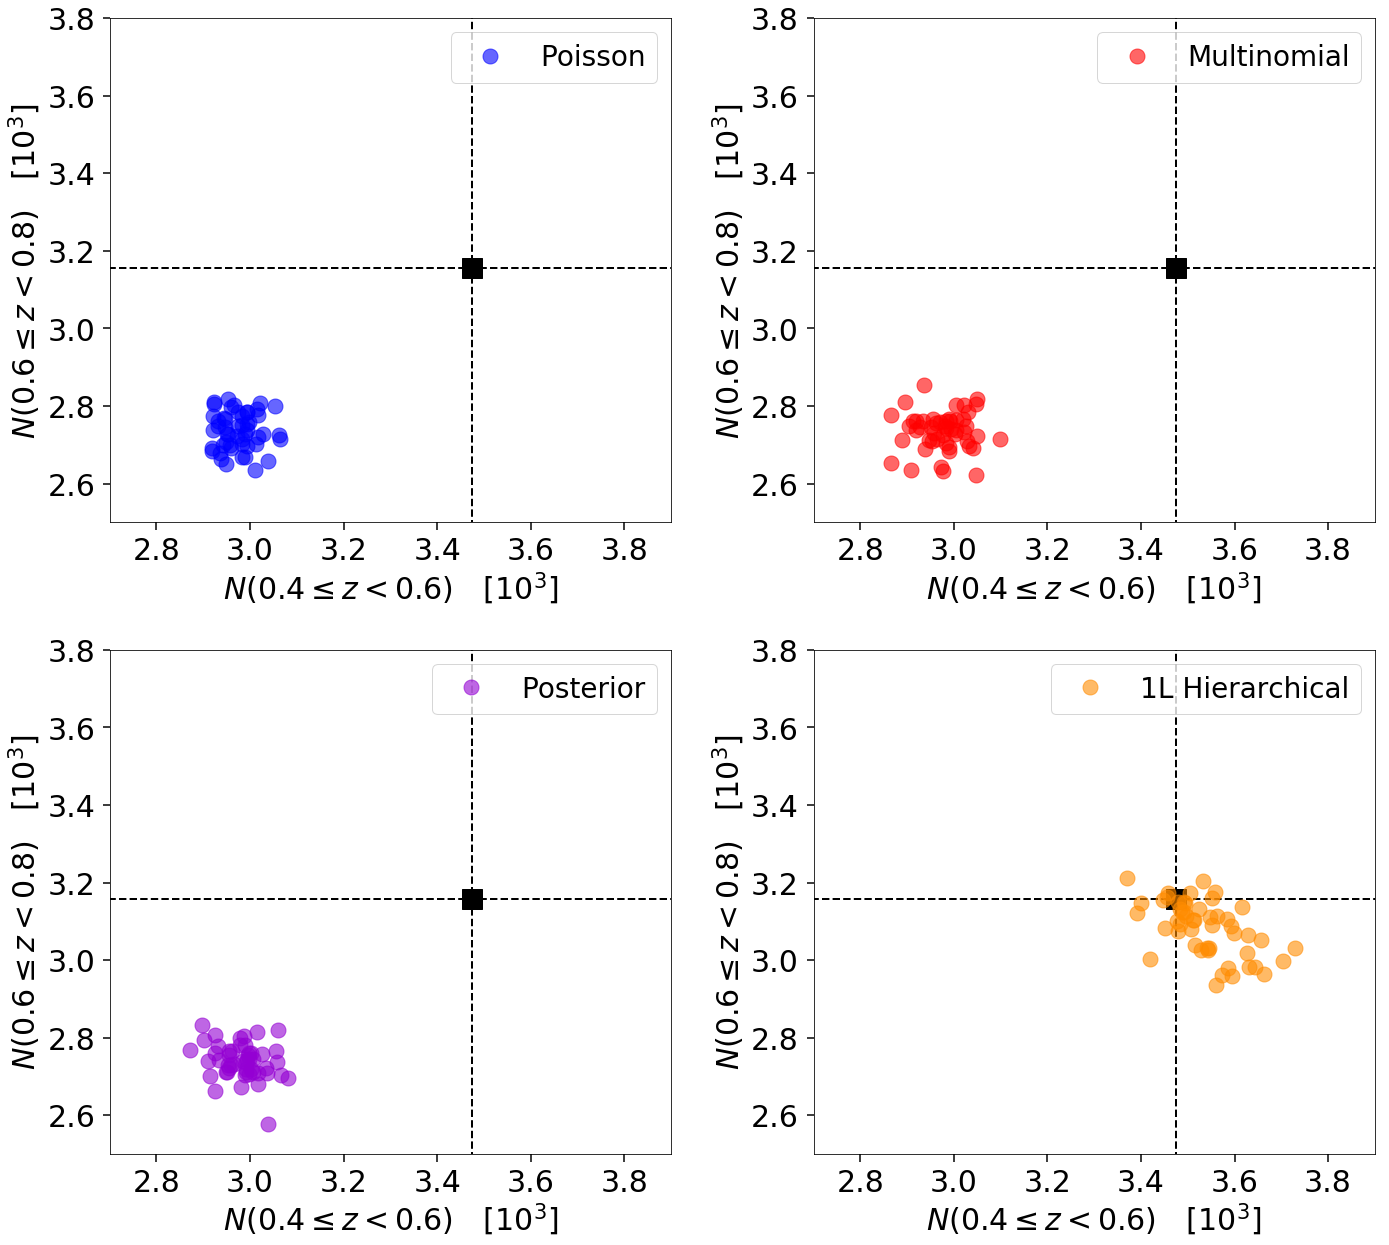

In [38]:
# plotting binned covariance
plt.figure(figsize=(20,18))
plt.subplot(2,2,1)
cov_draws(z1_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='blue', label='Poisson')
plt.subplot(2,2,2)
cov_draws(z2_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='red', label='Multinomial')
plt.subplot(2,2,3)
cov_draws(z3_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='darkviolet', label='Posterior')
plt.subplot(2,2,4)
cov_draws(z4_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='darkorange', label='1L Hierarchical')

## 2-Level Hierarchical

How about our 2-Level model?

In [39]:
# initialize scale
scale = alpha.copy()

In [40]:
# define target distributions
from scipy.special import gammaln, digamma, polygamma

def lnpost(alpha):
    """Log-posterior for `alpha` given `prior`."""
    
    lnp = gammaln(sum(alpha)) + sum((alpha - 1.) * np.log(prior) 
                                    - gammaln(alpha)
                                    - 2. * np.log(scale)
                                    + np.log(alpha)
                                    - (alpha**2 / scale**2))
    
    return lnp

def grad_lnp(alpha):
    """Gradient of the log-posterior for `alpha` given `prior`."""
    
    grad = (np.log(prior) - digamma(alpha) + digamma(sum(alpha)) 
            + (1. / alpha) - 2. * (alpha / scale**2))
    
    return grad

def hess_lnp(alpha):
    """Hessian of the log-posterior for `alpha` given `prior`."""
    
    hess = polygamma(1, sum(alpha)) * np.ones((alpha.shape[0], alpha.shape[0])) 
    hess -= np.diag(polygamma(1, alpha) * (1. / alpha**2) + (2. / scale**2))
    
    return hess

In [41]:
# initialize our HMC sampler

def leapfrog(L, epsilon, Minv, q, p, gradfn):
    """Leapfrog (second-order) integrator."""
    
    q_t, p_t = q.copy(), p.copy()  # initialize (position, momentum)
    p_t = p_t + 0.5 * epsilon * gradfn(q_t)  # initial momentum half-step
    q_t = q_t + epsilon * np.dot(Minv, p_t)  # initial position step
    for t in xrange(L):
        p_t = p_t + epsilon * gradfn(q_t)  # momentum step
        q_t = q_t + epsilon * np.dot(Minv, p_t)  # position step
    p_t = p_t + 0.5 * epsilon * gradfn(q_t)  # final momentum half-step
    
    return q_t, -p_t

def hmc_ltprob(lnp, p, lnp_new, p_new, Minv):
    """HMC log-transition probability."""
    
    H = -lnp + 0.5 * np.dot(p.T, np.dot(Minv, p))
    H_new = -lnp_new + 0.5 * np.dot(p_new.T, np.dot(Minv, p_new))
    lprob = H - H_new
    
    return lprob

def hmc_update(theta, lnp, L, epsilon, M, Minv, lnprobfn, gradfn):
    """Update the position of the chain using HMC."""
    
    p = np.random.multivariate_normal(np.zeros_like(theta), M)  # sample momentum 
    q, lnp = theta.copy(), lnp  # initial (position, momentum, lnP)
    q_out, p_out, = leapfrog(L, epsilon, Minv, q, p, gradfn)  # final (position, momentum)
    lnp_out = lnprobfn(q_out)  # final lnP
    ltprob = hmc_ltprob(lnp, p, lnp_out, p_out, Minv)  # log-transition probability
    
    # accept/reject
    if np.log(np.random.rand()) < ltprob:
        return q_out, lnp_out
    else:
        return q, lnp

def hmc_sampler(theta, N, L, epsilon, M, Minv, lnprobfn, gradfn, 
                stochastic=True, fvar=0.2, thin=1, nprint=100,
                verbose=False):
    """Our HMC sampler."""
    
    q = theta.copy()  # position 
    lnp = lnprobfn(q)  # lnP
    q_chain, lnp_chain = [], []  # intialize chain
    L_init, epsilon_init = np.copy(L), epsilon  # initialize integration parameters
    
    n, count = 0, 0
    while n < N:
        if verbose and n % nprint == 0 and count == 0: 
            sys.stderr.write(str(n)+' ')
        if stochastic:  # let L and epsilon slightly vary
            L = np.random.randint(L_init * (1 - fvar), L_init * (1 + fvar) + 1e-10)
            epsilon = np.random.uniform(epsilon_init * (1 - fvar), epsilon_init * (1 + fvar))
        q, lnp = hmc_update(q, lnp, L, epsilon, M, Minv, lnprobfn, gradfn)  # HMC update
        if (count + 1) % thin == 0:
            q_chain.append(q)
            lnp_chain.append(lnp)
            count = 0
            n += 1
        else:
            count += 1
        
    return np.array(q_chain), np.array(lnp_chain)

Building intuition for HMC...

In [42]:
L, epsilon = 10, 0.2  # path length, step-size
Niter = 50  # number of samples
mass = -hess_lnp(alpha)  # mass = -hessian
mass_inv = np.linalg.inv(mass)  # inverse mass matrix

# sample!
prior = train4_samples_pi[-1] + 1e-5 # pick a sample
pos, lnp = hmc_sampler(alpha, Niter, L, epsilon, mass, mass_inv,
                       lnpost, grad_lnp, nprint=1, verbose=True)

0 /home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: covariance is not positive-semidefinite.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

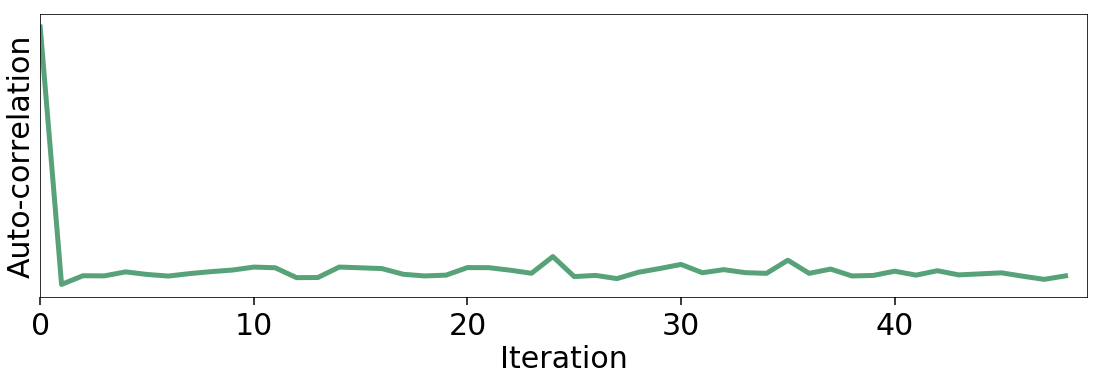

In [43]:
# plot lag=1 autocorrelation
plt.figure(figsize=(16, 6))
autocorr = np.array([np.correlate(pos[i], pos[i+1])
                     for i in range(len(pos) - 1)]).flatten()
plt.plot(autocorr, lw=5, color='seagreen', alpha=0.8)
plt.xlabel('Iteration')
plt.xlim([0., len(pos) - 1])
plt.yticks([])
plt.ylabel('Auto-correlation')
plt.tight_layout()

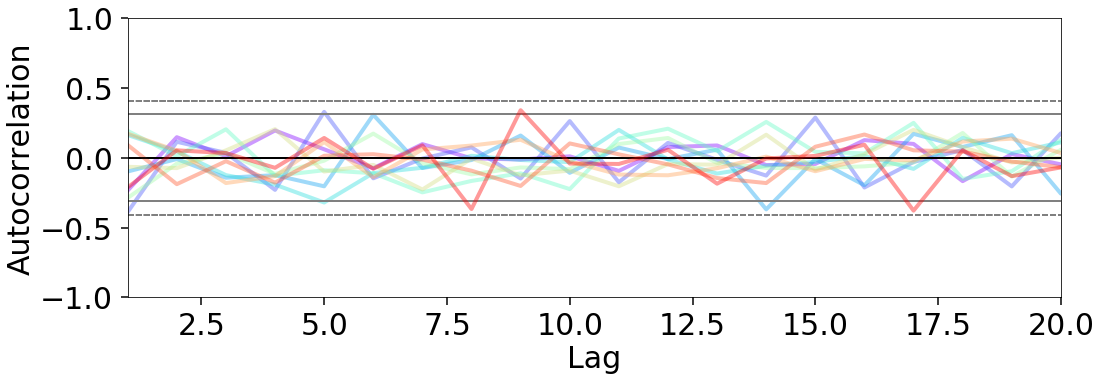

In [44]:
from pandas.plotting import autocorrelation_plot

# plot autocorrelation lag
Nburnin = 10
Nplot = 10
plt.figure(figsize=(16, 6))
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
idxs = np.random.choice(Ngrid, size=Nplot, replace=False)
[autocorrelation_plot(pos[Nburnin:, i], 
                      color=c, lw=4, alpha=0.4) 
 for i, c in zip(idxs, colors)]
plt.xlim([1, 20])
plt.tight_layout()

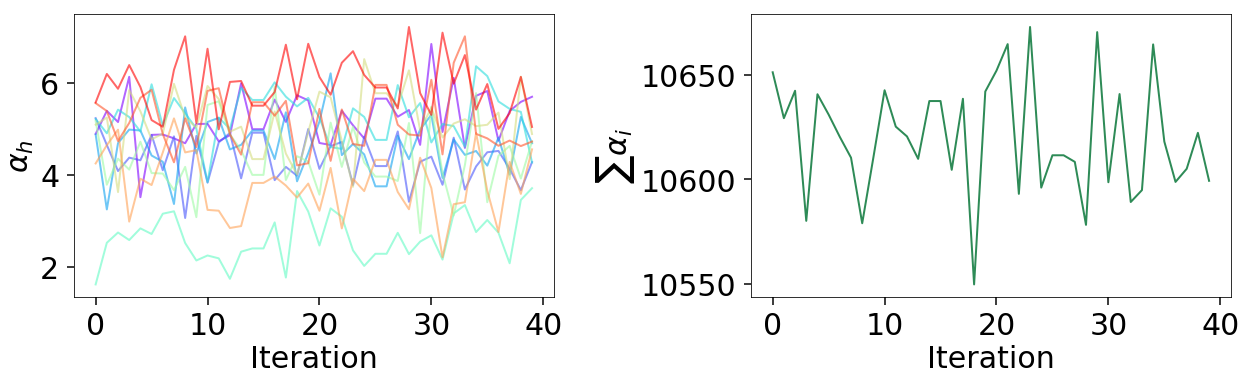

In [45]:
# plot alpha trace
plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
[plt.plot(pos[Nburnin:, i], color=c, alpha=0.6, lw=2) 
 for i,c in zip(idxs, colors)];
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha_h$')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(np.sum(pos[Nburnin:], axis=1), lw=2, color='seagreen')
plt.xlabel('Iteration')
plt.ylabel(r'$\sum \alpha_i$')
plt.tight_layout()

In [46]:
# define our HMC-in-Gibbs sampler

def mcmc_hmc_in_gibbs(pdfs, Nsamples, Ngrid,
                      lnprobfn, gradfn, hessfn,
                      Nburn=0, Nthin=1,
                      Nhmc=10, L=50, epsilon=0.05,
                      verbose=True):
    """Using MCMC with HMC-in-Gibbs sampling to sample from
    the joint distribution of our hierarchical model."""
    
    Nobs = len(pdfs)
    samples_pi = np.zeros((Nsamples, Ngrid))
    samples_n = np.zeros((Nsamples, Ngrid), dtype='int')
    samples_alpha = np.zeros((Nsamples, Ngrid))

    prior = np.ones(Ngrid)  # initialize weights
    alpha = scale.copy()  # initialize alpha
    for j in range(Nthin * (Nsamples + Nburn)):
        count = int(j / Nthin) - Nburn
        if verbose and (j + 1) % Nthin == 0: 
            sys.stderr.write('{0} '.format(count))

        # Compute new posterior.
        nstack = np.zeros(Ngrid)
        pdf_t = pdfs * prior
        pdf_t /= pdf_t.sum(axis=1)[:, None]

        # Stack posterior.
        for i in range(Nobs):
            nstack += np.random.multinomial(1, pdf_t[i])

        # Sample population weights.
        prior = np.random.dirichlet(nstack + alpha) * Nobs + 1e-5
        
        # Sample concentration parameters.
        mass = -hessfn(alpha)  # mass = -hessian
        mass_inv = np.linalg.inv(mass)  # inverse mass matrix
        pos, lnp = hmc_sampler(alpha, Nhmc, L, epsilon, mass, 
                               mass_inv, lnprobfn, gradfn)
        alpha = pos[-1]

        # Save samples.
        if (j + 1) % Nthin == 0 and count >= 0:
            samples_n[count] = nstack.copy()
            samples_pi[count] = prior.copy()
            samples_alpha[count] = alpha.copy()
            
    return samples_n, samples_pi, samples_alpha

Building intuition for joint sampling...

In [47]:
# sample from our 2-level hierarchical model
results = mcmc_hmc_in_gibbs(post, 150, Ntrain, 
                            lnpost, grad_lnp, hess_lnp,
                            Nburn=0, Nthin=1, Nhmc=5,
                            L=10, epsilon=0.2)
train5_samples_n, train5_samples_pi, train5_samples_alpha = results

0 /home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: covariance is not positive-semidefinite.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 

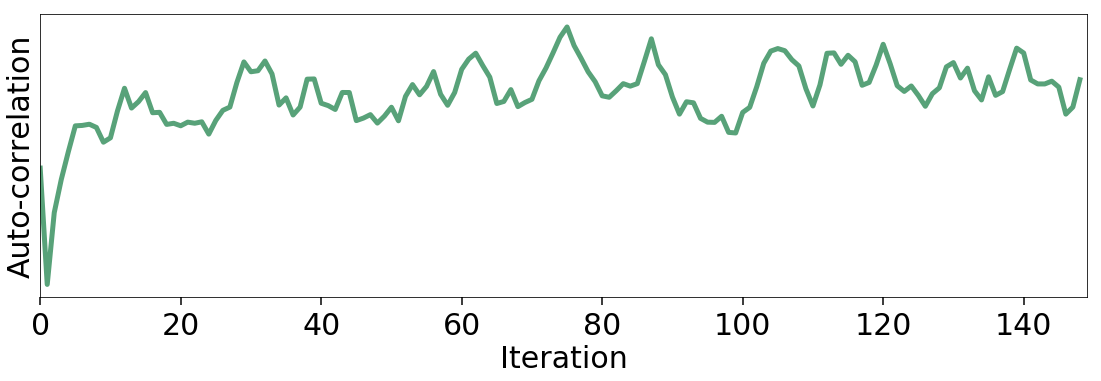

In [48]:
# plot lag=1 autocorrelation
plt.figure(figsize=(16, 6))
autocorr = np.array([np.correlate(train5_samples_pi[i], train5_samples_pi[i+1])
                     for i in range(len(train5_samples_n) - 1)]).flatten()
plt.plot(autocorr, lw=5, color='seagreen', alpha=0.8)
plt.xlabel('Iteration')
plt.xlim([0., len(train5_samples_n) - 1])
plt.yticks([])
plt.ylabel('Auto-correlation')
plt.tight_layout()

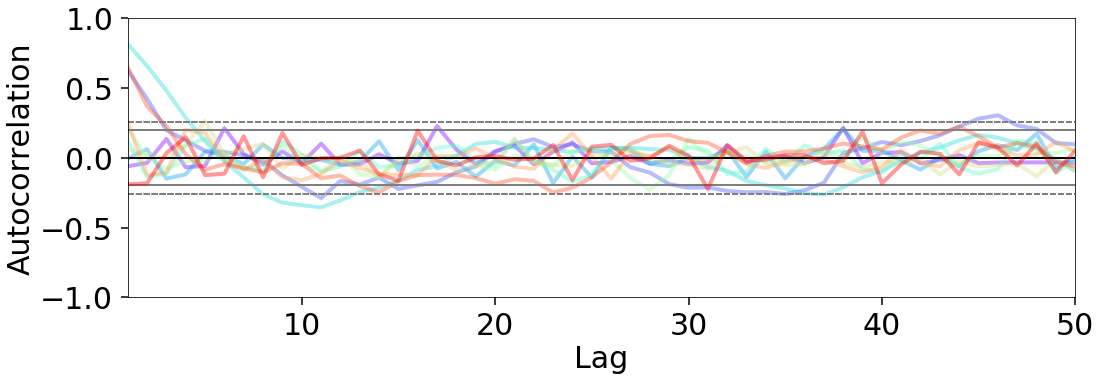

In [49]:
# plot autocorrelation lag
Nburnin = 50
Nplot = 10
plt.figure(figsize=(16, 6))
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
idxs = np.random.choice(len(zgrid), size=Nplot, replace=False)
[autocorrelation_plot(train5_samples_pi[Nburnin:, i], 
                      color=c, lw=4, alpha=0.4) 
 for i, c in zip(idxs, colors)]
plt.xlim([1, (len(train5_samples_n) - Nburnin) / 2])
plt.tight_layout()

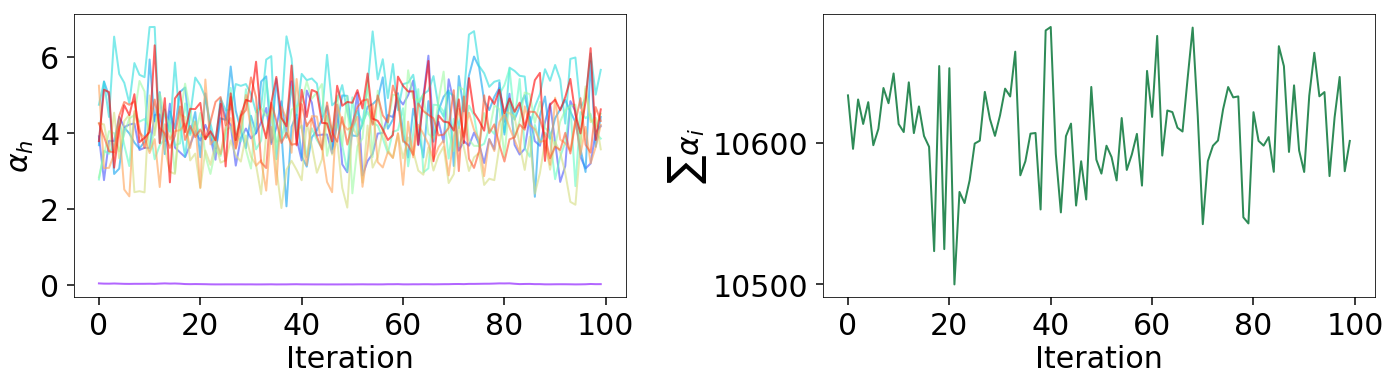

In [50]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
[plt.plot(train5_samples_alpha[Nburnin:, i], color=c, 
          lw=2, alpha=0.6) 
 for i,c in zip(idxs, colors)];
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha_h$')
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.plot(np.sum(train5_samples_alpha[Nburnin:], axis=1), 
         lw=2, color='seagreen')
plt.xlabel('Iteration')
plt.ylabel(r'$\sum \alpha_i$')
plt.tight_layout()

Now let's sample!

In [51]:
# sample from our 2-level hierarchical model
(train5_samples_n, train5_samples_pi, 
 train5_samples_alpha) = (train5_samples_n[Nburnin::2], 
                          train5_samples_pi[Nburnin::2], 
                          train5_samples_alpha[Nburnin::2])

In [52]:
# draw redshift samples
from scipy.stats import truncnorm
z5_samples = np.zeros_like(z4_samples)
for i in range(Nsamples):
    sys.stderr.write('{0} '.format(i))
    zsamps = []
    for j in range(Ntrain):
        for k in range(train5_samples_n[i][j]):
            zsamps.append(truncnorm.rvs(a=-mu_train[j]/sigma_train[j], b=np.inf,
                                        loc=mu_train[j], scale=sigma_train[j]))
    z5_samples[i] = frankenz.pdf.gauss_kde(zsamps, np.ones_like(zsamps) * sgrid,
                                           zgrid)  # KDE
    z5_samples[i] *= len(zsamps) / z5_samples[i].sum()  # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

# Results

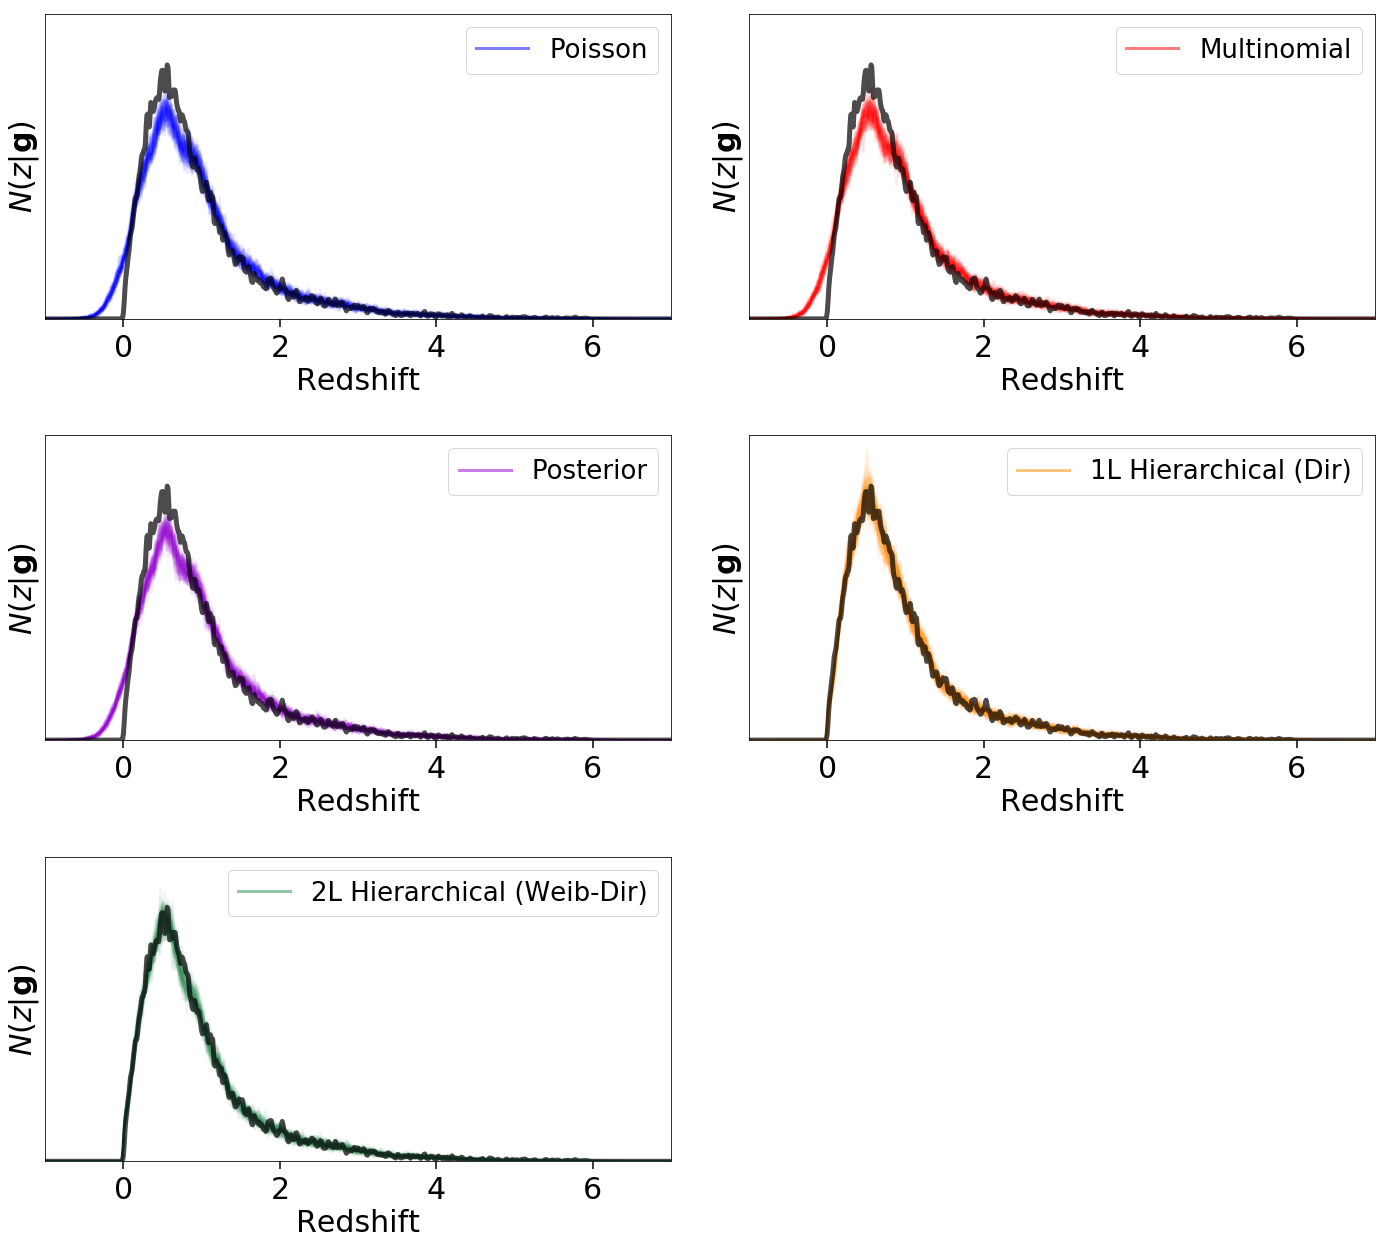

In [53]:
# plotting
plt.figure(figsize=(20, 18))
plt.subplot(3, 2, 1)
zplot(z1_samples, label='Poisson', color='blue')
plt.subplot(3, 2, 2)
zplot(z2_samples, label='Multinomial', color='red')
plt.subplot(3, 2, 3)
zplot(z3_samples, label='Posterior', color='darkviolet')
plt.subplot(3, 2, 4)
zplot(z4_samples, label='1L Hierarchical (Dir)', color='darkorange')
plt.subplot(3, 2, 5)
zplot(z5_samples, label='2L Hierarchical (Weib-Dir)', color='seagreen')

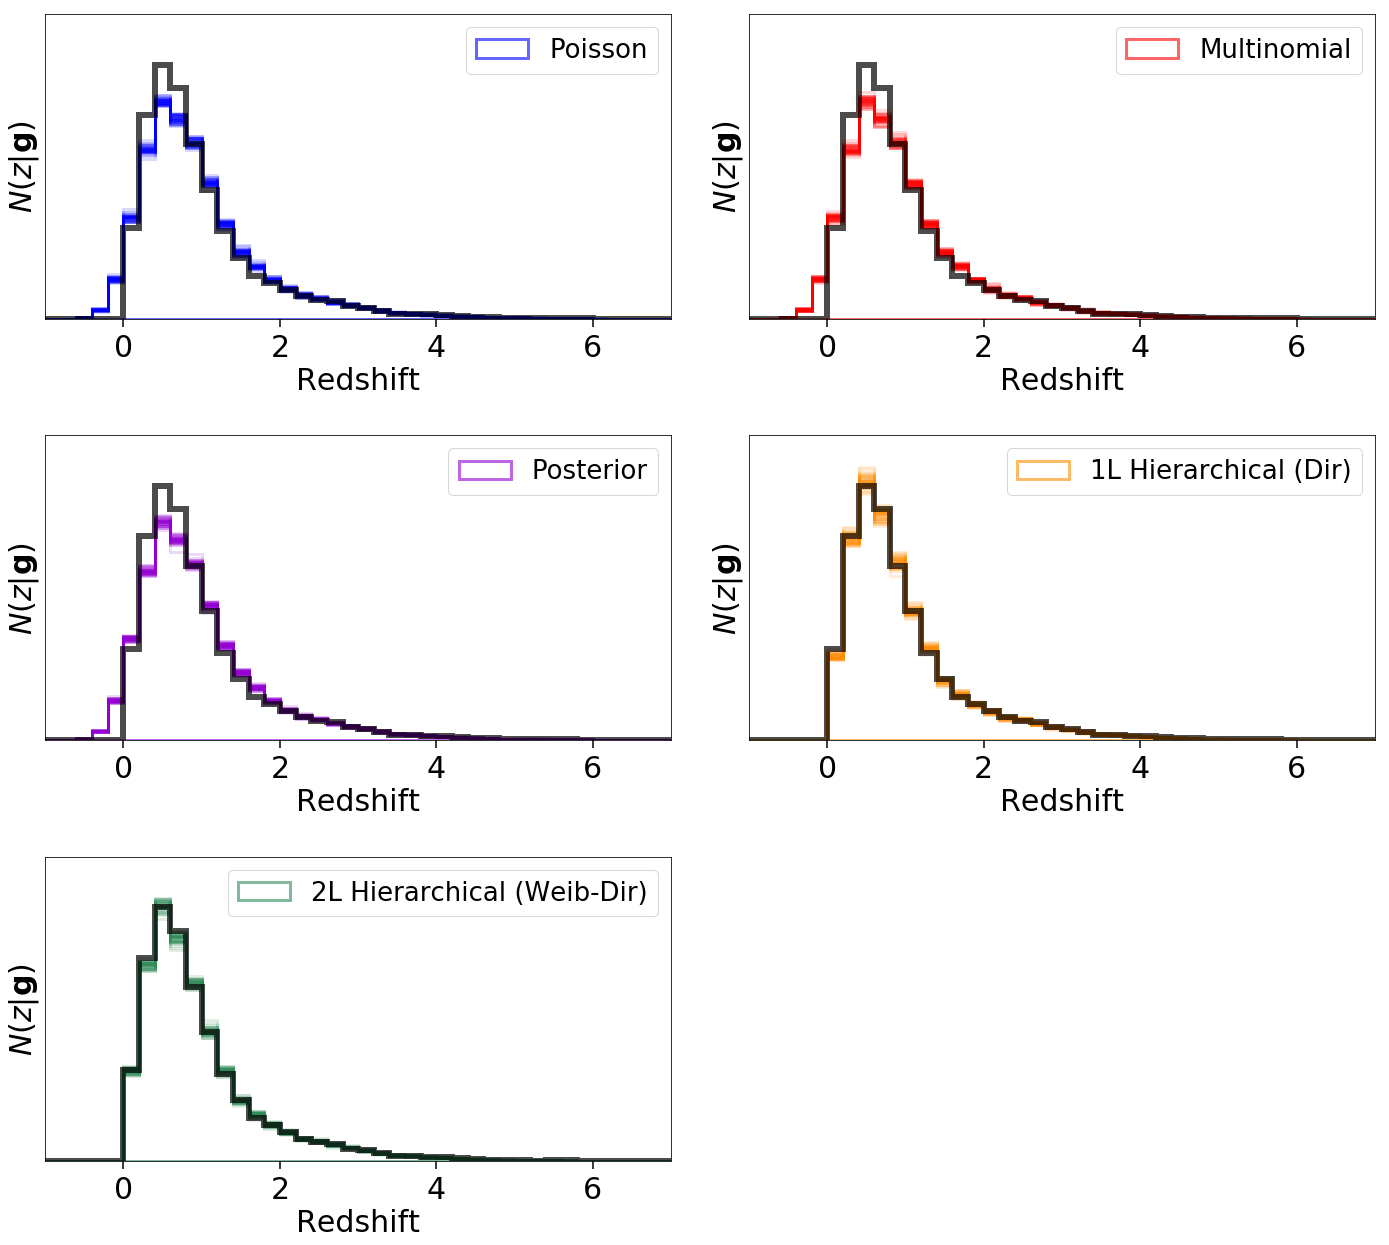

In [54]:
# plotting binned results
plt.figure(figsize=(20, 18))
plt.subplot(3, 2, 1)
zplot_bin(z1_samples, label='Poisson', color='blue', binning=20)
plt.subplot(3, 2, 2)
zplot_bin(z2_samples, label='Multinomial', color='red', binning=20)
plt.subplot(3, 2, 3)
zplot_bin(z3_samples, label='Posterior', color='darkviolet', binning=20)
plt.subplot(3, 2, 4)
zplot_bin(z4_samples, label='1L Hierarchical (Dir)', color='darkorange', binning=20)
plt.subplot(3, 2, 5)
zplot_bin(z5_samples, label='2L Hierarchical (Weib-Dir)', color='seagreen', binning=20)

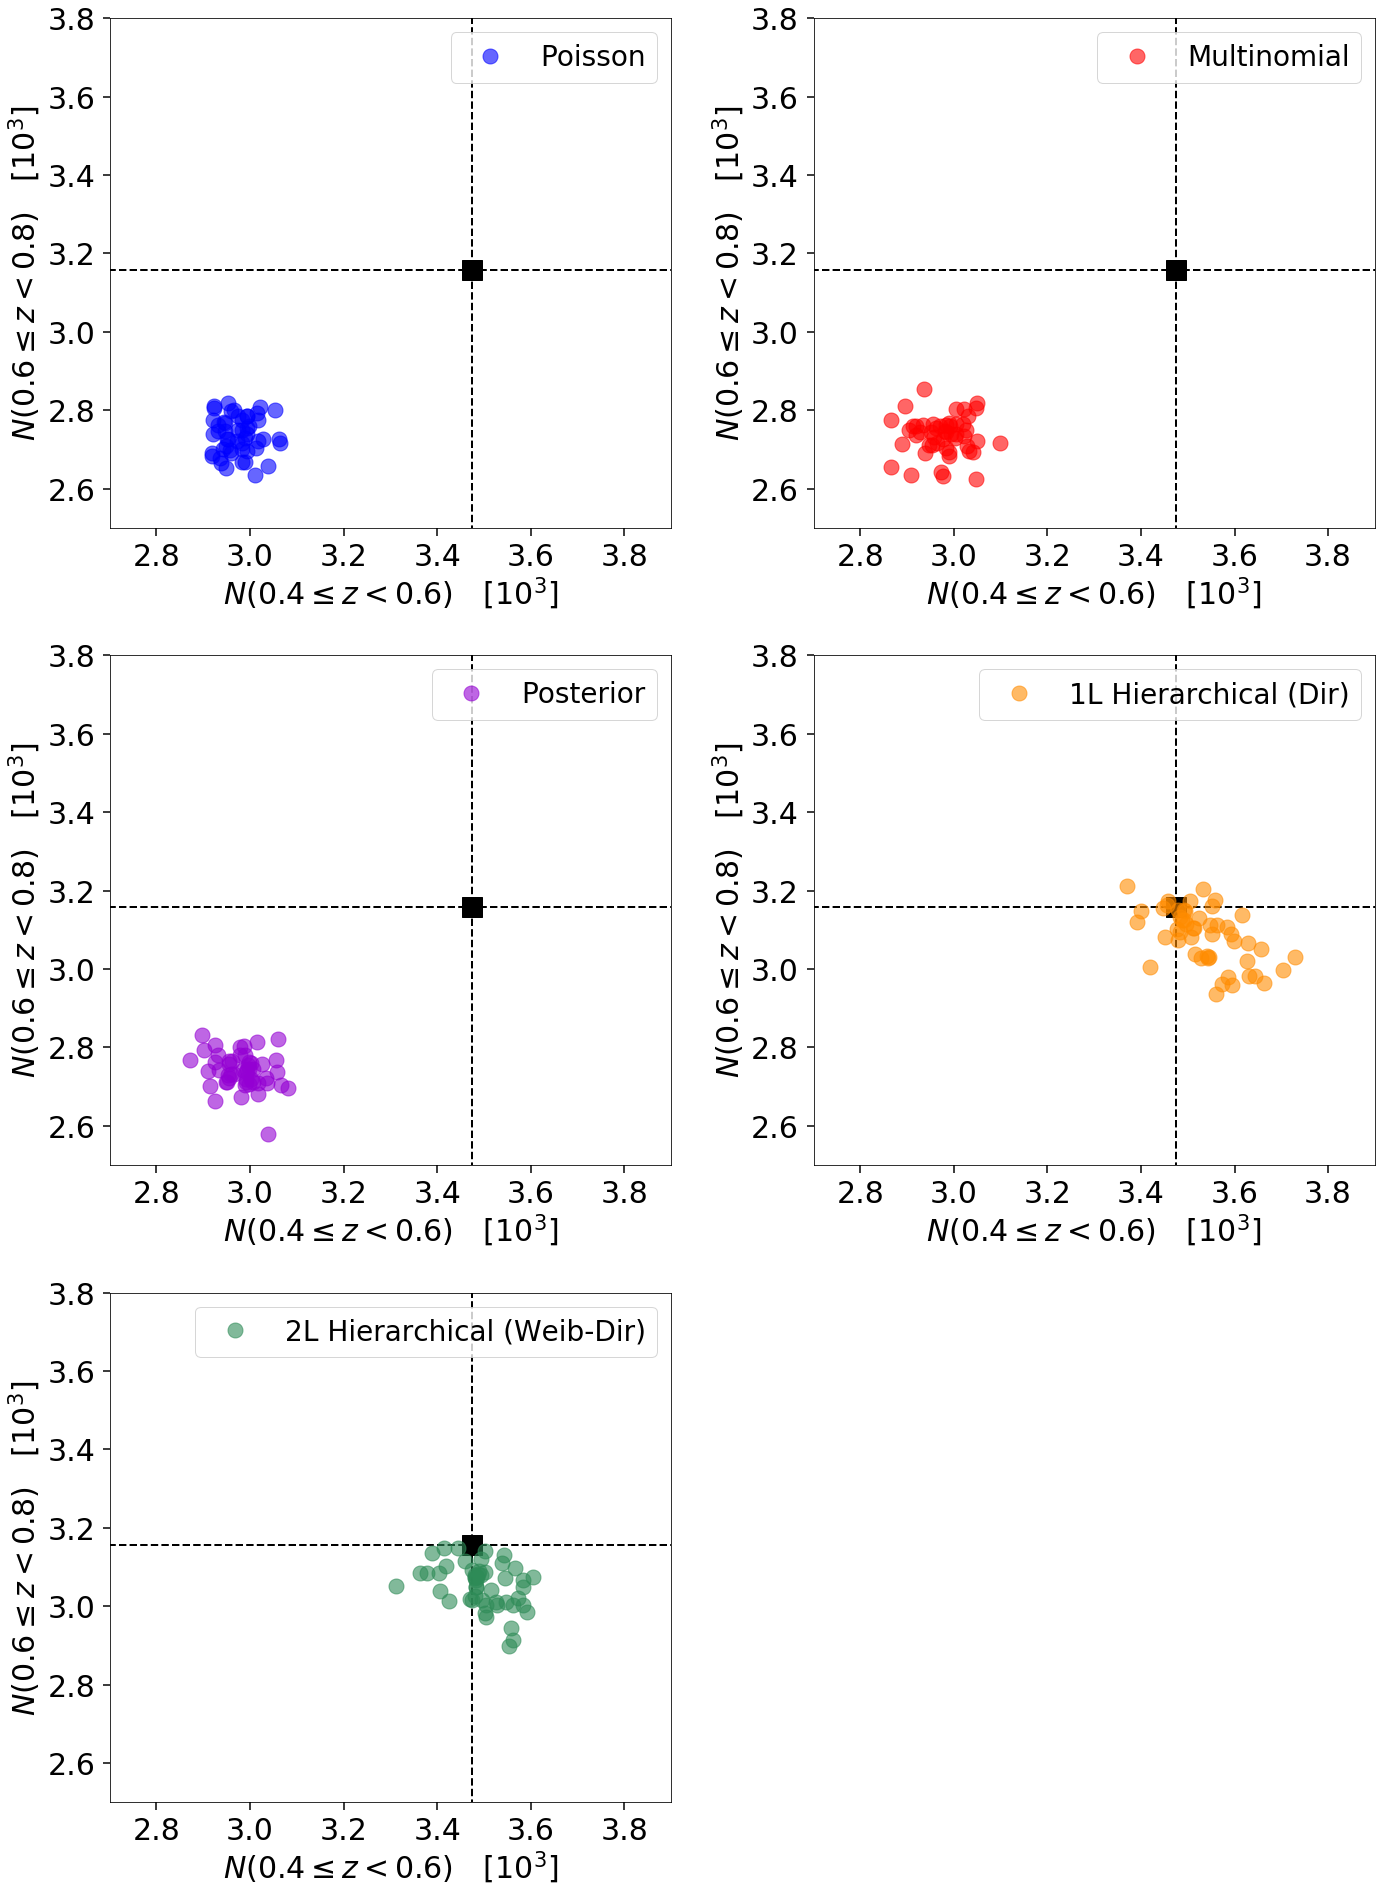

In [55]:
# plotting binned covariance
plt.figure(figsize=(20,27))
plt.subplot(3,2,1)
cov_draws(z1_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='blue', label='Poisson')
plt.subplot(3,2,2)
cov_draws(z2_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='red', label='Multinomial')
plt.subplot(3,2,3)
cov_draws(z3_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='darkviolet', label='Posterior')
plt.subplot(3,2,4)
cov_draws(z4_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='darkorange', label='1L Hierarchical (Dir)')
plt.subplot(3,2,5)
cov_draws(z5_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.7, 3.9), ylim=(2.5, 3.8),
          color='seagreen', label='2L Hierarchical (Weib-Dir)')

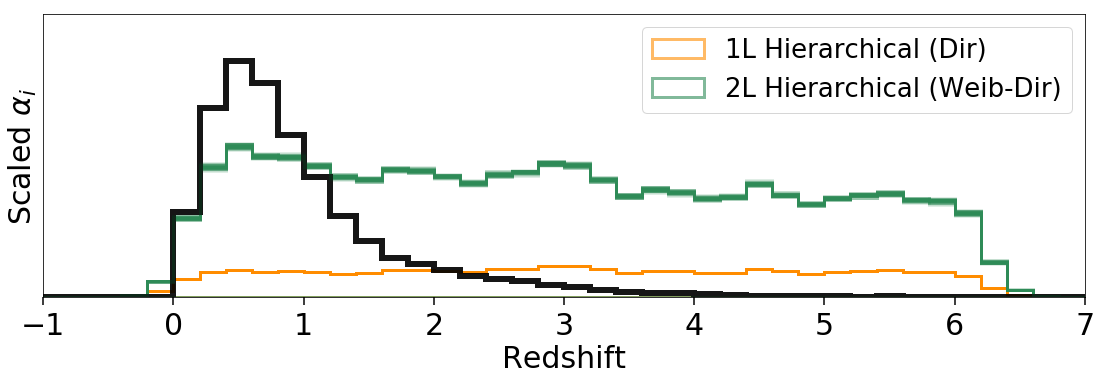

In [56]:
# plotting binned alphas
alpha = np.array([np.trapz(frankenz.pdf.gaussian(m, s, zgrid) * hside, zgrid)
                  for m, s in zip(mu_train, sigma_train)])
h1_zpdf = frankenz.pdf.gauss_kde(mu_train, sigma_train, zgrid, y_wt=alpha)
plt.figure(figsize=(16, 6))
zplot_bin(np.array([h1_zpdf for i in range(Nsamples)]) * 5, 
          label='1L Hierarchical (Dir)', color='darkorange', 
          binning=20)
zplot_bin([frankenz.pdf.gauss_kde(mu_train, sigma_train, zgrid, y_wt=p5a) * 5
           for p5a in train5_samples_alpha],
          label='2L Hierarchical (Weib-Dir)', color='seagreen',
          binning=20)
plt.ylabel(r'Scaled $\alpha_i$')
plt.tight_layout()